In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
# Function which generates the initial state based on how many stations there are
def generate_init_state(nr_of_stations):
    state = np.concatenate(
        ([{"jobs_in_buffer":0,"jobs_in_service":0,"jobs_in_BAS":0} for i in range(0, nr_of_stations)], [0])
    )
    return state

# Function which generates a new event and returns the updated list of future events
def add_new_event(planned_events, event_type, rate, current_time):
    new_event = (event_type, current_time + np.random.exponential(1/rate))  # generate new event with time stamp
    if len(planned_events) > 0:  # if the current list of events is non empty
        i = 0  # start at the first event
        for event in planned_events:  # iterate over all planned events, it is assumed this list is already ordered
            if event[1] > new_event[1]:  # place new event in the right spot
                planned_events.insert(i, new_event)
                break
            else:
                i += 1
        if i == len(planned_events):
            planned_events.append(new_event)
    else:
        planned_events.append(new_event)
    return planned_events


# Function which updates the current state and future events if the next event is an arrival
def handle_arrival_event(state_, events_, params, current_time):
    if state_[0]["jobs_in_buffer"] < params["buffer_sizes"][0]:  # if the arrival can enter the system
        if state_[0]["jobs_in_service"] == params["servers_per_station"][0] or state_[0]["jobs_in_BAS"] > 0:
            state_[0]["jobs_in_buffer"] += 1  # put job in buffer if all servers are full or if server is blocked
        else:
            state_[0]["jobs_in_service"] += 1  # put job in server if there is a server available
            events_ = add_new_event(events_, 'B1', params["service_rates"][0], current_time)  # add service event to list
    events_ = add_new_event(events_, 'A', params["arrival_rate"], current_time)  # add new arrival event to list
    return state_, events_

# Function which updates the current state and future events if the next event is a departure
def handle_departure_event(state_, events_, params, station, current_time):
    station_index = station  # index to track station
    
    # Handle what happens with the job that has been served (forward update)
    if station_index == params["nr_of_stations"]: 
        state_[station_index-1]["jobs_in_service"]-=1
        state_[station_index]+=1 
    else:
        if state_[station_index]["jobs_in_buffer"] == 0:  # if the next queue is empty
            if state_[station_index]["jobs_in_service"] == params["servers_per_station"][station_index] or \
               state_[station_index]["jobs_in_BAS"] > 0:
                state_[station_index-1]["jobs_in_service"] -= 1
                state_[station_index]["jobs_in_buffer"] += 1
            else:
                state_[station_index-1]["jobs_in_service"]-= 1
                state_[station_index]["jobs_in_service"] += 1
                events_ = add_new_event(events_, 'B'+str(station_index+1), params["service_rates"][station_index], current_time)  
        elif state_[station_index]["jobs_in_buffer"] < params["buffer_sizes"][station_index]: # if the next queue is non-empty, but not full
            state_[station_index-1]["jobs_in_service"] -= 1
            state_[station_index]["jobs_in_buffer"] += 1
        else:
            state_[station_index - 1]["jobs_in_BAS"] += 1  # if the next queue is full
            state_[station_index - 1]["jobs_in_service"] -= 1 
    
    # Handle what happens with the possibly open server that the completed job created (backward update)
    for i in reversed(range(0, station_index)):
        if state_[i]["jobs_in_BAS"] == 0 and \
           state_[i]["jobs_in_buffer"] > 0 and \
           state_[i]["jobs_in_service"] < params["servers_per_station"][i]:
            state_[i]["jobs_in_buffer"] -= 1
            state_[i]["jobs_in_service"] += 1
            events_ = add_new_event(events_, 'B'+str(i+1), params["service_rates"][i], current_time)
            if i > 0 and state_[i-1]["jobs_in_BAS"] > 0:
                state_[i-1]["jobs_in_BAS"] -= 1
                state_[i]["jobs_in_buffer"] += 1
            else:
                break
        else:
            break
    return state_, events_
            
            
# Function which updates the current state and future events and returns them
def update_event_state(state_, events_, params):
    next_event = events_.pop(0)  # take the next event from the future events list
    if next_event[0] == 'A':  # if the event is an arrival
        state, events = handle_arrival_event(state_, events_, params, next_event[1]) 
    if next_event[0][0] == 'B':  # if the event is an departure
        station = int(next_event[0][1])  # at station i
        state, events = handle_departure_event(state_, events_, params, station, next_event[1])        
    return state, events

# Function which runs the main state/event loop of the tandem queue
def tandem_queue(nr_of_stations, servers_per_station, buffer_sizes, arrival_rate, service_rates, horizon, print_states):
    time = []
    jobs_completed = []
    state = generate_init_state(nr_of_stations)  # generate initial state
    events = [('A', 0)]  # initial future events
    params = {"nr_of_stations":nr_of_stations,
              "servers_per_station":servers_per_station,
              "buffer_sizes":buffer_sizes,
              "arrival_rate":arrival_rate,
              "service_rates":service_rates
              }  # dictionairy of parameters
    while(events[0][1] < horizon):  # while the next event time stamp is before horizon
        if print_states:
            print(state)
            print(events)
        state, events = update_event_state(state, events, params)  # update state and future events
        time.append(events[0][1])
        jobs_completed.append(state[nr_of_stations])
    return time, jobs_completed
    

[{'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0} 0]
[('A', 0)]
[{'jobs_in_buffer': 0, 'jobs_in_service': 1, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0} 0]
[('A', 0.33873793533888397), ('B1', 0.4910665577362314)]
[{'jobs_in_buffer': 1, 'jobs_in_service': 1, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jobs_in_BAS': 0} 0]
[('A', 0.3649727751304256), ('B1', 0.4910665577362314)]
[{'jobs_in_buffer': 2, 'jobs_in_service': 1, 'jobs_in_BAS': 0}
 {'jobs_in_buffer': 0, 'jobs_in_service': 0, 'jo

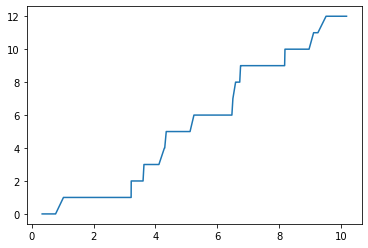

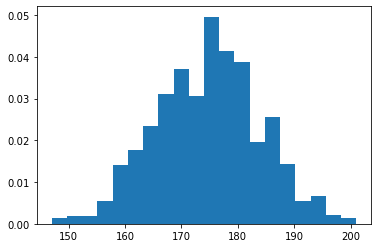

In [3]:
# a single simulation of a tandem queue with BAS
time, jobs_completed = tandem_queue(nr_of_stations = 4, 
             servers_per_station = [1,1,1,1],
            buffer_sizes = [5,6,6,3],
            arrival_rate = 2.1,
            service_rates = [2.9,2.2,2.2,2.8],
            horizon = 10,
            print_states = True)

# plot the amount of jobs completed over time
fig, ax = plt.subplots()
ax.plot(time, jobs_completed)

nr_of_simulations = 1000
throughput = []
for i in range(0, nr_of_simulations):
    time, jobs_completed = tandem_queue(
            nr_of_stations = 4, 
            servers_per_station = [1,1,1,1],
            buffer_sizes = [5,6,6,3],
            arrival_rate = 2.1,
            service_rates = [2.9,2.2,2.2,2.8],
            horizon = 100,
            print_states = False)
    throughput.append(jobs_completed[-1])

fig, ax = plt.subplots()
ax.hist(throughput, bins = 20, density = True)
plt.show()


